<h1 style="text-align: center;">ENERGY CONSUMPTION PREDICTION</h1>
<h1 style="text-align: center;">(PART-2 Feature Engineering and Selection)</h1>

# From Previous Notebook ...

## - Importing Necessary Libraries

In [1]:
# Importing needed libraries to be used throughout the project

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import gc

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## - Loading and Reducing Memory Usage of Data

In [2]:
data_path = "feather_data/"

train_path = data_path + "train_data.feather"

building_path = data_path + "building_data.feather"

weather_train_path = data_path + "weather_train_data.feather"

In [3]:
train_data = pd.read_feather(train_path)

building_data = pd.read_feather(building_path)

weather_train_data = pd.read_feather(weather_train_path)

In [4]:
# This function helps in optimizing the memory used by the dataframes by by modifying/altering thedatatype of each column.
# This method is inspired from the kaggle notebook titled: load data (reduce memory usage)
# Which is found at: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df, df_name):

    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage of {} is reduced by {:.2f} %. Usage dropped from {:.2f} MB to {:.2f} MB.'.format(df_name, (100 * (start_mem - end_mem) / start_mem), start_mem, end_mem))
    
    return df


In [5]:
# Reducing Memory Usage of Data

train_data = reduce_mem_usage(train_data, 'Train Data')

building_data = reduce_mem_usage(building_data, 'Building Data')

weather_train_data = reduce_mem_usage(weather_train_data, 'Weather Train Data')

Memory usage of Train Data is reduced by 71.82 %. Usage dropped from 616.95 MB to 173.84 MB.
Memory usage of Building Data is reduced by 73.88 %. Usage dropped from 0.07 MB to 0.02 MB.
Memory usage of Weather Train Data is reduced by 73.06 %. Usage dropped from 9.60 MB to 2.59 MB.


In [6]:
# Merging Data

train = train_data.merge(building_data, on='building_id', how='left')
train = train.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')

In [7]:
# Breaking Timestamp into Hour, Day, Month, Year

# This function firstly converts timestamp to date and then breaks down date into 6 new columns: hour, day, dayOfWeek, dayOfYear, month and year

def breakdown_timestamp(dataframe):
    
    dataframe['timestamp']= pd.to_datetime(dataframe['timestamp'])

    dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
    
    dataframe['day']= np.uint16(dataframe['timestamp'].dt.day)
    dataframe['dayofweek']= np.uint8(dataframe['timestamp'].dt.dayofweek)
    dataframe['dayofyear']= np.uint16(dataframe['timestamp'].dt.dayofyear)

    dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)

    dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
    
    return dataframe

In [8]:
train = breakdown_timestamp(train)

## - Applying Log Transformation to 'Meter Reading and 'Square Feet'

In [9]:
train['meter_reading'] = np.log1p(train['meter_reading'])

In [10]:
train['square_feet'] = np.log1p(train['square_feet'])

# 5. Feature Engineering

**Preprocessing and Data Preparation Steps:**
1. Removing rows with zero meter readings as they may indicate an inaccurate or unavailable reading.
2. Setting a threshold limit to drop columns with more than 50 % missing values.
3. Filling in missing values using column median.
4. Adding new features.
5. Encoding categorical data.

## 5.1 Removing Zero Meter Readings

In [11]:
zero_meter_readings = list(train[train['meter_reading'] == 0].index)
train.drop(zero_meter_readings, axis = 0, inplace = True)

In [12]:
print('New Shape of Train Data:',train.shape)

New Shape of Train Data: (18342124, 22)


## 5.2 Dropping Columns with More than 50 % Missing Values

In [13]:
threshold = len(train) * 0.5
train.dropna(axis=1, thresh = threshold, inplace = True)

In [14]:
print('New Shape of Train Data:',train.shape)

New Shape of Train Data: (18342124, 20)


## 5.3 Filling Missing Values

In [15]:
train['cloud_coverage'].fillna(train['cloud_coverage'].median(), inplace=True)
train['sea_level_pressure'].fillna(train['sea_level_pressure'].median(), inplace=True)
train['precip_depth_1_hr'].fillna(train['precip_depth_1_hr'].median(), inplace=True)
train['wind_direction'].fillna(train['wind_direction'].median(), inplace=True)
train['wind_speed'].fillna(train['wind_speed'].median(), inplace=True)
train['dew_temperature'].fillna(train['dew_temperature'].median(), inplace=True)
train['air_temperature'].fillna(train['air_temperature'].median(), inplace=True)

In [16]:
train.isnull().sum() / len(train)

building_id           0.0
meter                 0.0
timestamp             0.0
meter_reading         0.0
site_id               0.0
primary_use           0.0
square_feet           0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
precip_depth_1_hr     0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
hour                  0.0
day                   0.0
dayofweek             0.0
dayofyear             0.0
month                 0.0
year                  0.0
dtype: float64

## 5.4 Adding New Features

In [17]:
# adding new feature from existing ones to get better results

train['season'] = train['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else 
                                                  'Summer' if x.month==6 or x.month==7 or x.month==8 else 
                                                  'Autumn' if x.month==9 or x.month==10 or x.month==11 else 
                                                  'Winter')

train['isDayTime'] = train['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)

In [18]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isDayTime
45,46,0,2016-01-01,3.993413,0,Retail,9.110078,25.000000,6.0,20.000000,...,0.0,0.000000,0,1,4,1,1,2016,Winter,0
72,74,0,2016-01-01,3.784219,0,Parking,12.867830,25.000000,6.0,20.000000,...,0.0,0.000000,0,1,4,1,1,2016,Winter,0
91,93,0,2016-01-01,3.978196,0,Office,10.415443,25.000000,6.0,20.000000,...,0.0,0.000000,0,1,4,1,1,2016,Winter,0
103,105,0,2016-01-01,3.190624,1,Education,10.832181,3.800781,0.0,2.400391,...,240.0,3.099609,0,1,4,1,1,2016,Winter,0
104,106,0,2016-01-01,0.318163,1,Education,8.589514,3.800781,0.0,2.400391,...,240.0,3.099609,0,1,4,1,1,2016,Winter,0


## 5.5 Encoding categorical data

In [19]:
categorical_features = ['primary_use', 'season']

In [20]:
encoder = preprocessing.LabelEncoder()

for i in categorical_features:
    
    train[i] = encoder.fit_transform(train[i])
    
print (train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18342124 entries, 45 to 20216099
Data columns (total 22 columns):
 #   Column              Dtype   
---  ------              -----   
 0   building_id         int16   
 1   meter               int8    
 2   timestamp           category
 3   meter_reading       float32 
 4   site_id             int8    
 5   primary_use         int32   
 6   square_feet         float64 
 7   air_temperature     float16 
 8   cloud_coverage      float16 
 9   dew_temperature     float16 
 10  precip_depth_1_hr   float16 
 11  sea_level_pressure  float16 
 12  wind_direction      float16 
 13  wind_speed          float16 
 14  hour                uint8   
 15  day                 uint16  
 16  dayofweek           uint8   
 17  dayofyear           uint16  
 18  month               uint8   
 19  year                uint16  
 20  season              int32   
 21  isDayTime           int64   
dtypes: category(1), float16(7), float32(1), float64(1), int16(1), int32(

In [21]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isDayTime
45,46,0,2016-01-01,3.993413,0,11,9.110078,25.000000,6.0,20.000000,...,0.0,0.000000,0,1,4,1,1,2016,3,0
72,74,0,2016-01-01,3.784219,0,8,12.867830,25.000000,6.0,20.000000,...,0.0,0.000000,0,1,4,1,1,2016,3,0
91,93,0,2016-01-01,3.978196,0,6,10.415443,25.000000,6.0,20.000000,...,0.0,0.000000,0,1,4,1,1,2016,3,0
103,105,0,2016-01-01,3.190624,1,0,10.832181,3.800781,0.0,2.400391,...,240.0,3.099609,0,1,4,1,1,2016,3,0
104,106,0,2016-01-01,0.318163,1,0,8.589514,3.800781,0.0,2.400391,...,240.0,3.099609,0,1,4,1,1,2016,3,0


# 6. Feature Selection

**Using LGBM to Select the Best Features that Actually Affect the Model Results**

In [22]:
train = train.drop(['timestamp'],axis=1)

**Reducing the Memory Usage Again**

In [23]:
reduced_train_data = reduce_mem_usage(train, 'Train Data')

Memory usage of Train Data is reduced by 28.57 %. Usage dropped from 1102.02 MB to 787.16 MB.


**Creating Training and Testing Data for the Model to Work With**

In [24]:
x = reduced_train_data.drop(['meter_reading'],axis=1)

In [25]:
y = reduced_train_data['meter_reading']

**Running The Feature Selection Model**

In [26]:
parameters = {
    
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'subsample': 0.2,
    'learning_rate': 0.9,  # 0.3 #0.5 #0.6 
    'feature_fraction': 0.9, #0.5 #0.6 #0.8
    'bagging_fraction': 0.9, #0.8
    'alpha': 0.1,
    'lambda': 0.1,
    'num_leaves': 110, #110 #100 #150 large, but over-fitting
    'max_bin': 66,  #60 #50 # large,but slower,over-fitting
    'max_depth': 10, # deal with over-fitting
    'min_data_in_leaf': 30, # deal with over-fitting

}


kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

models = []

for train_index, val_index in kf.split(x):
    train_x = x.iloc[train_index]
    val_x = x.iloc[val_index]
    train_y = y.iloc[train_index]
    val_y = y.iloc[val_index]
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(val_x, val_y) 

    gbm = lgb.train(parameters,
                    lgb_train,
                    num_boost_round=100,  # increase this since early stopping will kick in
                    valid_sets=[lgb_train, lgb_eval],
                    callbacks=[early_stopping(stopping_rounds=10), log_evaluation(10)])

    
    models.append(gbm)
    
gc.collect()

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.2 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.2 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.217350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 14673699, number of used features: 20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.2 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Start training from score 4.569452
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.795073	valid_1's rmse: 0.795143
[20]	training's rmse: 0.702375	valid_1's rmse: 0.702675
[30]	training's rmse: 0.650739	valid_1's rmse: 0.650892
[40]	trainin

472

**Visualizing the Feature Importance Highlighted by the Model**

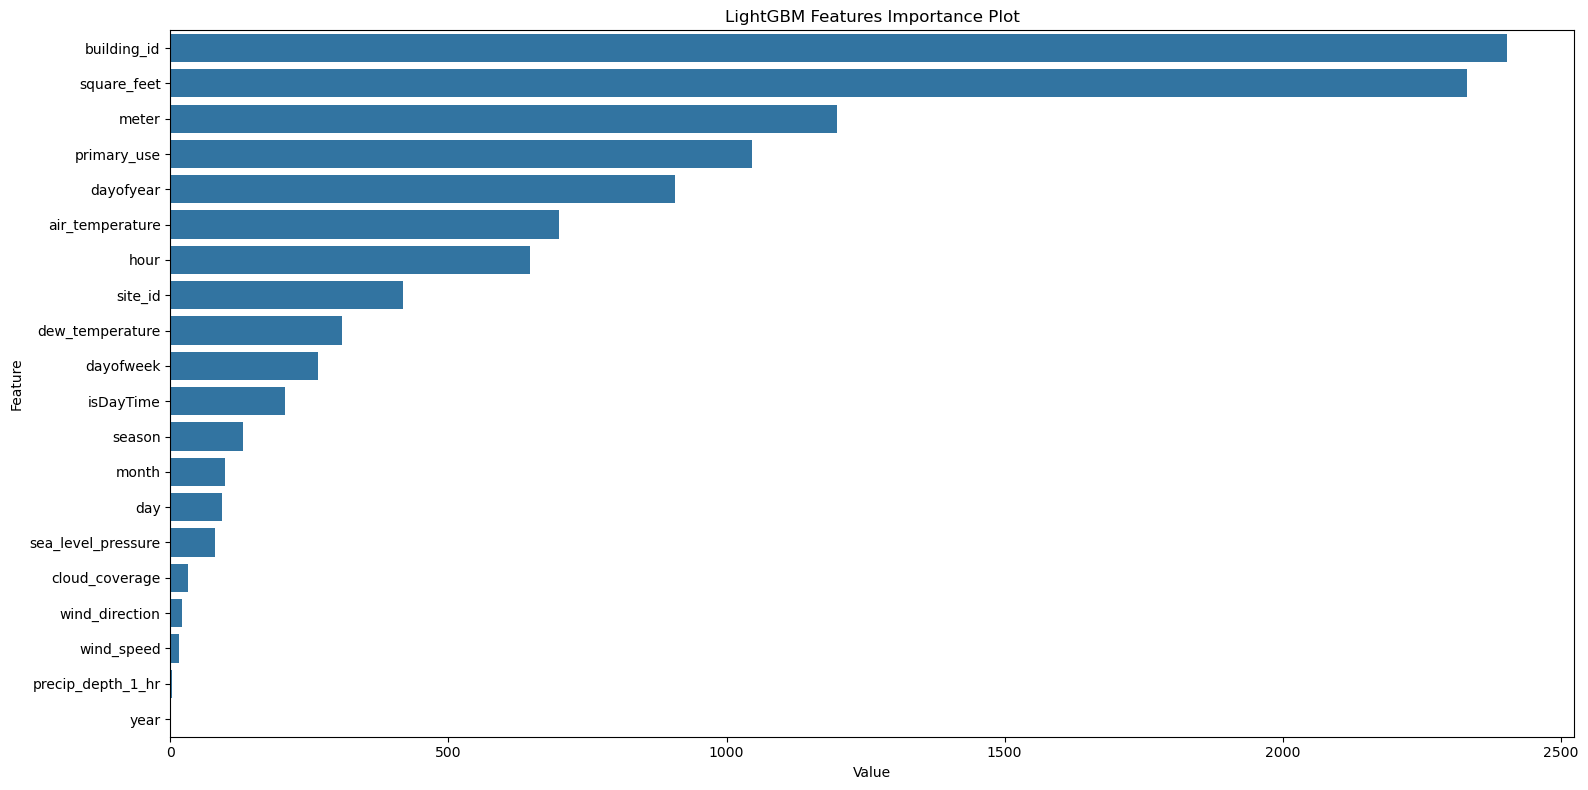

In [27]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])

plt.figure(figsize=(16, 8))

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

plt.title('LightGBM Features Importance Plot')

plt.tight_layout()

plt.show()

**Removing the Least Important Features as Indicated by the Feature Selection Method**

In [28]:
new_data = reduced_train_data[['building_id','square_feet','primary_use','meter','site_id','air_temperature','dayofyear','hour','isDayTime','dew_temperature','dayofweek', 'meter_reading']]

**Creating a Heatmap to See the Correlated Features in the New Data**

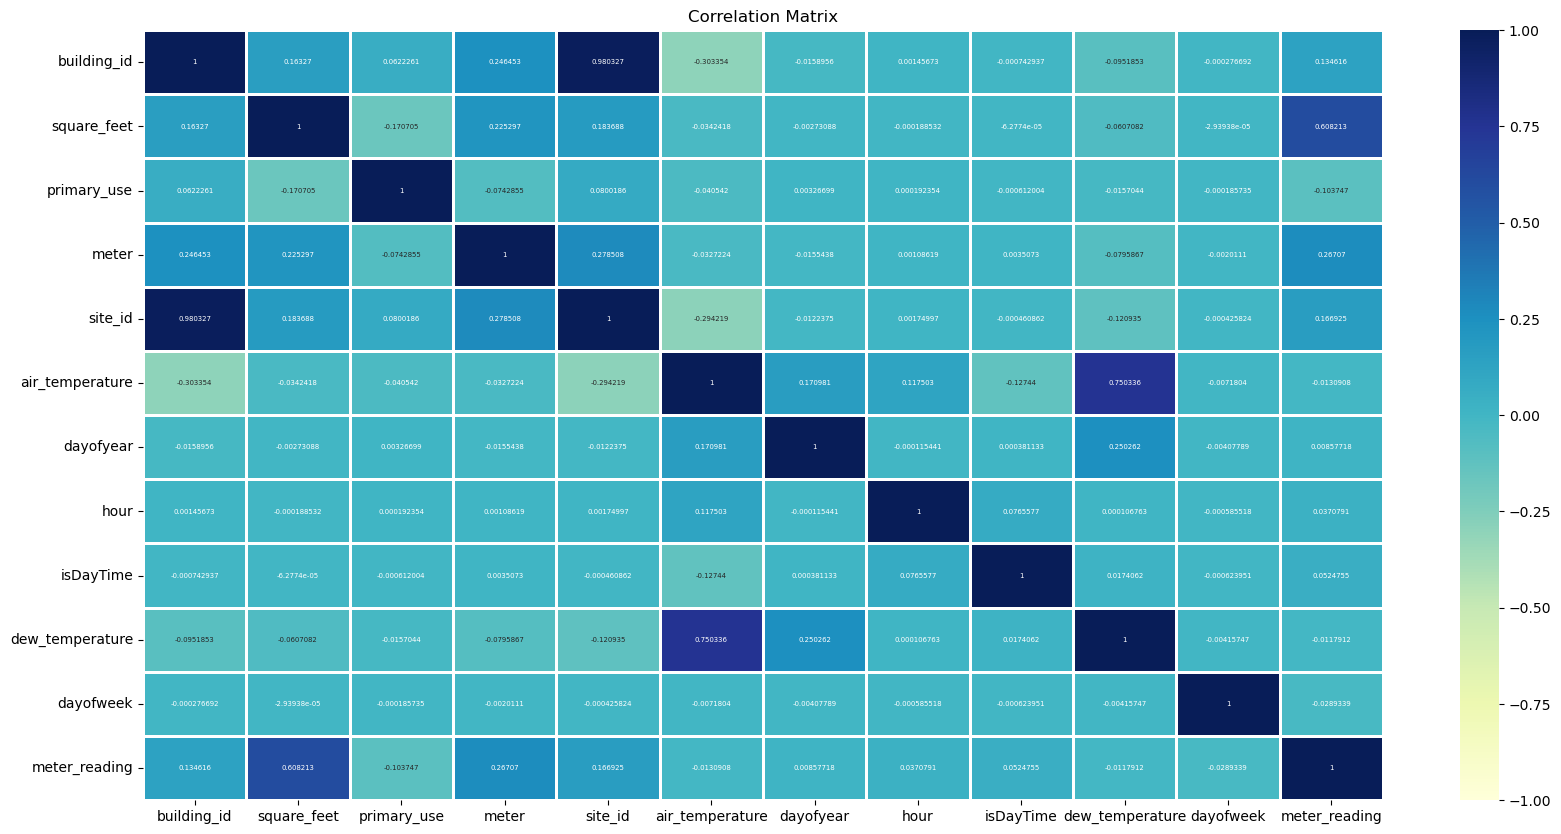

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(
    new_data.corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    linewidths=1,
    annot_kws={"size": 5},
    fmt="g",
    ax=ax,
    cmap="YlGnBu"
)

ax.set_title('Correlation Matrix')
plt.show()


**Removing Highly Correlated Features**

In [30]:
new_data.drop(['site_id','dew_temperature'],axis = 1,inplace=True)

**Creating Another Heatmap to Verify that there are no Further Improvements to be Done**

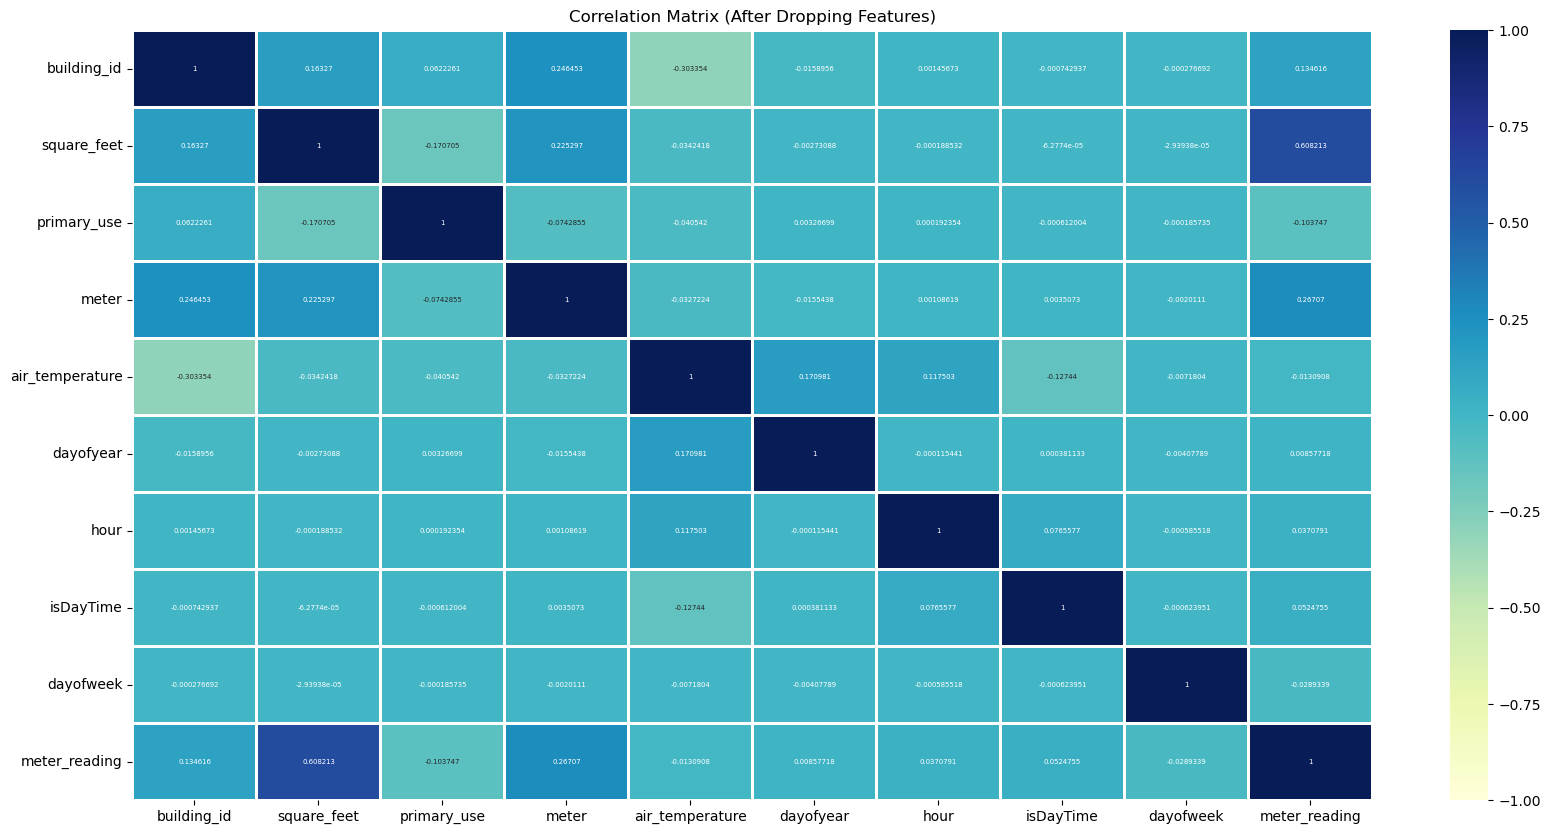

In [31]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(new_data.corr(), annot=True, vmin=-1, vmax=1, linewidths=1,
            annot_kws={"size": 5}, fmt="g", ax=ax, cmap="YlGnBu")
ax.set_title('Correlation Matrix (After Dropping Features)')
plt.show()